# **Dicoding Submission - Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series**

**Samatha Marhaendra Putra**

Data Source: https://www.kaggle.com/datasets/jaganadhg/house-hold-energy-data

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jaganadhg/house-hold-energy-data -f D202.csv

D202.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/D202.csv.zip

Archive:  /content/D202.csv.zip
replace D202.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: D202.csv                


In [7]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('/content/D202.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


# **Data Preprocessing**

#### Renaming the column names

In [10]:
df.columns = ['type', 'date', 'start_time', 'end_time', 'usage', 'units', 'cost', 'notes']

#### Checking if there is any null value or not

In [11]:
df.isna().sum()

type              0
date              0
start_time        0
end_time          0
usage             0
units             0
cost              0
notes         70368
dtype: int64

#### Dropping unecessary columns

In [12]:
df = df.drop(['type', 'units', 'cost', 'notes', 'start_time', 'end_time'], axis=1)

#### Grouping data by 'date' column

In [13]:
df = df.groupby(['date']).sum().reset_index()

#### Changing the 'date' column data type to datetime

In [14]:
df['date'] = df['date'].astype('datetime64[ns]')

#### Sorting the dataset by 'date' column

In [15]:
df = df.sort_values('date')

In [16]:
df.head()

,date,usage
90,2016-10-22,4.52
93,2016-10-23,23.32
96,2016-10-24,7.16
99,2016-10-25,8.68
101,2016-10-26,5.04


Text(0.5, 1.0, 'San Jose Apartment Energy Consumption')

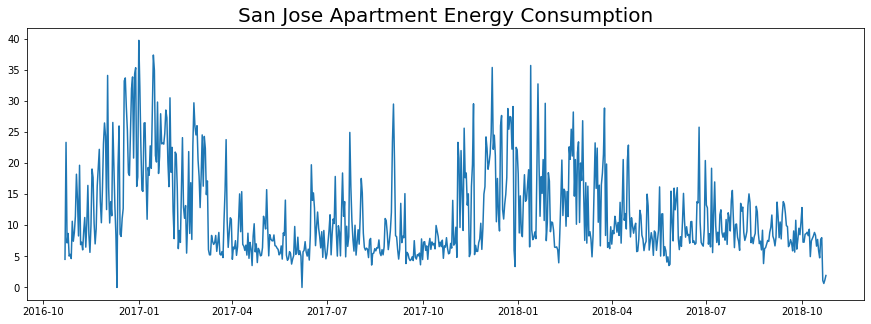

In [17]:
dates = df['date'].values
usage = df['usage'].values

plt.figure(figsize=(15,5))
plt.plot(dates, usage)
plt.title('San Jose Apartment Energy Consumption', fontsize=20)

#### Data Splitting

In [18]:
dates_train, dates_test, usage_train, usage_test = train_test_split(dates, usage, test_size=0.2, shuffle=False)

#### Changing the format of the dataset so that it can be consumed by the deep learning model

In [19]:
def windowed_dataset(series_train, series_val, window_size, batch_size, shuffle_buffer):
  series_train = tf.expand_dims(series_train, axis=-1)
  ds_train = tf.data.Dataset.from_tensor_slices(series_train)
  ds_train = ds_train.window(window_size + 1, shift=1, drop_remainder=True)
  ds_train = ds_train.flat_map(lambda w: w.batch(window_size + 1))
  ds_train = ds_train.shuffle(shuffle_buffer)
  ds_train = ds_train.map(lambda w: (w[:-1], w[-1:]))
  ds_train = ds_train.batch(batch_size).prefetch(1)

  series_val = tf.expand_dims(series_val, axis=-1)
  ds_val = tf.data.Dataset.from_tensor_slices(series_val)
  ds_val = ds_val.window(window_size + 1, shift=1, drop_remainder=True)
  ds_val = ds_val.flat_map(lambda w: w.batch(window_size + 1))
  ds_val = ds_val.shuffle(shuffle_buffer)
  ds_val = ds_val.map(lambda w: (w[:-1], w[-1:]))
  ds_val = ds_val.batch(batch_size).prefetch(1)

  return [ds_train, ds_val]

In [20]:
train_set, test_set = windowed_dataset(usage_train, usage_test, window_size=60, batch_size=100, shuffle_buffer=1000)

# **Model Development**

#### Architecting the model

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#### Creating callback function

In [23]:
mae_thres = (df['usage'].max() - df['usage'].min()) * 10/100

class customCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < mae_thres):
      print("\nReached MAE < %2.2f%%, stopping training . . ." %mae_thres)
      self.model.stop_training = True

callbacks = customCallback()

#### Training the model

In [24]:
history = model.fit(train_set, epochs=500, validation_data=test_set, callbacks=[callbacks])

Epoch 1/500
6/6 [==============================] - 13s 530ms/step - loss: 11.7508 - mae: 12.2501 - val_loss: 8.0054 - val_mae: 8.5050
Epoch 2/500
6/6 [==============================] - 0s 23ms/step - loss: 11.6586 - mae: 12.1578 - val_loss: 7.9466 - val_mae: 8.4459
Epoch 3/500
6/6 [==============================] - 0s 24ms/step - loss: 11.6345 - mae: 12.1335 - val_loss: 7.9435 - val_mae: 8.4427
Epoch 4/500
6/6 [==============================] - 0s 23ms/step - loss: 11.6270 - mae: 12.1260 - val_loss: 7.9216 - val_mae: 8.4208
Epoch 5/500
6/6 [==============================] - 0s 23ms/step - loss: 11.6040 - mae: 12.1031 - val_loss: 7.8879 - val_mae: 8.3870
Epoch 6/500
6/6 [==============================] - 0s 22ms/step - loss: 11.5757 - mae: 12.0748 - val_loss: 7.8632 - val_mae: 8.3622
Epoch 7/500
6/6 [==============================] - 0s 23ms/step - loss: 11.5431 - mae: 12.0422 - val_loss: 7.8325 - val_mae: 8.3314
Epoch 8/500
6/6 [==============================] - 0s 23ms/step - loss: 11

#### Creating MAE plot

In [25]:
def plot_metric(history, metric):
  train_metrics = history.history[metric]
  val_metrics = history.history['val_' + metric]
  epochs = range(1, len(train_metrics) + 1)
  plt.rcParams["figure.figsize"] = (6,8)
  plt.plot(epochs, train_metrics)
  plt.plot(epochs, val_metrics)
  plt.title('Training and Validation ' + metric.upper())
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(["train_" + metric, 'val_' + metric], loc="best")
  plt.show()

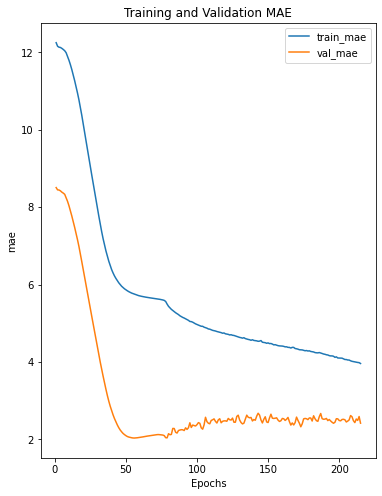

In [26]:
plot_metric(history, 'mae')